In [1]:
# Display plots directly in the notebook instead of in a new window
%matplotlib inline

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest
import patsy

In [2]:
# Loading data from datasets
df_capes = pd.read_csv("CapesCleanedEnrolled.csv")
df_income = pd.read_csv("income_dataset.csv")
df_capes

,Unnamed: 0,Instructor,Department,Rcmnd Instr,Average Grade Expected,Classes Taught,Enrolled
0,0,"Ben-Yosef, Erez",Anthropology,100.000000,3.6400,1.0,19.0
1,1,"D'Alpoim Guedes, Jade A",Anthropology,100.000000,3.7500,1.0,39.0
2,2,"Marchetto, Maria Carolina",Anthropology,100.000000,3.9100,1.0,25.0
3,3,"Non, Amy L",Anthropology,90.966667,3.2800,3.0,91.0
4,4,"Lew, Caroline Horton",Anthropology,88.100000,3.6850,2.0,72.0
...,...,...,...,...,...,...,...
1534,1534,"Pafunda, Danielle",Literature,98.075000,3.8075,4.0,139.0
1535,1535,"Johnson, Sara E.",Literature,97.200000,3.6900,1.0,45.0
1536,1536,"Morse, Ainsley",Literature,100.000000,3.7000,2.0,30.0
1537,1537,"Kokotovic, Milos",Literature,100.000000,3.7550,2.0,43.0


In [3]:
# Standardizing the strings in order to combine 
def last_name(string):
    end = string.find(',')
    return string[0:end].upper()

def first_name(string):
    start = string.find(',')
    name = string[start+2:].upper()
    space = name.find(' ')
    if (space != -1):
        return name[:space+2]
    return name

def uppercase(string):
    return string.upper()

def first_name_income(string):
    name = string.upper()
    space = name.find(' ')
    if (space != -1):
        return name[:space+2]
    return name

In [4]:
# Standardizing Capes Set
df_capes['Last Name'] = df_capes['Instructor'].apply(last_name)
df_capes['First Name'] = df_capes['Instructor'].apply(first_name)
df_capes['Instructor'] = df_capes['Last Name'] + ', ' + df_capes['First Name']

# Standardizing Income Set
df_income['First Name'] = df_income['First Name'].apply(first_name_income)
df_income['Instructor'] = df_income['Last Name'] + ', ' + df_income['First Name']

In [5]:
# Merge datasets and get rid of merge columns
df = df_income.merge(df_capes, on=['Instructor'])
df = df.drop(['Unnamed: 0_x', 'Last Name_x', 'First Name_x', 'Instructor', 'Unnamed: 0_y', 'Last Name_y', 'First Name_y'], axis=1)
df

,Title,Regular Pay,Department,Rcmnd Instr,Average Grade Expected,Classes Taught,Enrolled
0,LECTURER - ACADEMIC YEAR,40000.0,Electrical & Computer Eng.,95.120000,3.802000,5.0,196.0
1,LECTURER - ACADEMIC YEAR - ONE OR TWO QUARTERS,10000.0,Psychology,97.000000,3.250000,1.0,52.0
2,LECTURER - ACADEMIC YEAR - CONTINUING,50000.0,Chemistry,90.575000,3.115000,4.0,1356.0
3,LECTURER - ACADEMIC YEAR - ONE OR TWO QUARTERS,20000.0,Mathematics,90.450000,3.350000,2.0,491.0
4,LECTURER - ACADEMIC YEAR - CONTINUING,130000.0,Education Studies,97.900000,3.980000,1.0,55.0
...,...,...,...,...,...,...,...
1030,PROF - ACADEMIC YEAR - B/E/E,200000.0,Rady School of Management,82.200000,3.810000,1.0,52.0
1031,ASST PROF - ACADEMIC YEAR,100000.0,Chemistry,92.300000,3.125000,2.0,513.0
1032,VIS ASSOC PROF,140000.0,Rady School of Management,91.216667,3.546667,6.0,401.0
1033,PROF - ACADEMIC YEAR,140000.0,Mathematics,96.150000,3.210000,2.0,43.0


In [6]:
# Adding new column to adjust pay for amount of students taught
df['Pay per Student'] = df['Regular Pay'] / df['Enrolled']

# Start of Data Analysis

## Distributions and Getting rid of Outliers

(array([934.,  62.,  17.,   8.,   7.,   4.,   2.,   0.,   0.,   1.]),
 array([1.09289617e+01, 4.00983607e+03, 8.00874317e+03, 1.20076503e+04,
        1.60065574e+04, 2.00054645e+04, 2.40043716e+04, 2.80032787e+04,
        3.20021858e+04, 3.60010929e+04, 4.00000000e+04]),
 <a list of 10 Patch objects>)

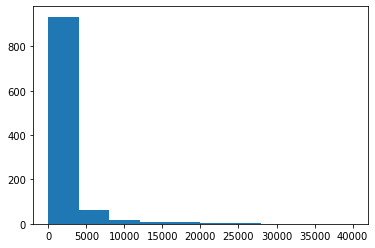

In [7]:
# Distribution for Pay per Student
# Highly right skewed
plt.hist(df['Pay per Student'])

In [8]:
# Determine Outliers for Pay per Student
lower, upper = np.percentile(df['Pay per Student'], [25, 75])
iqr = upper - lower
lower_cutoff = lower - 1.5 * iqr
upper_cutoff = upper + 1.5 * iqr
print("Lower 25: ", lower_cutoff, "\nUpper 25: ", upper_cutoff)

df = (df[(df['Pay per Student'] >= lower_cutoff) & (df['Pay per Student'] <= upper_cutoff)])
df

Lower 25:  -1864.0041980974304 
Upper 25:  3737.8382555355743


,Title,Regular Pay,Department,Rcmnd Instr,Average Grade Expected,Classes Taught,Enrolled,Pay per Student
0,LECTURER - ACADEMIC YEAR,40000.0,Electrical & Computer Eng.,95.120000,3.802000,5.0,196.0,204.081633
1,LECTURER - ACADEMIC YEAR - ONE OR TWO QUARTERS,10000.0,Psychology,97.000000,3.250000,1.0,52.0,192.307692
2,LECTURER - ACADEMIC YEAR - CONTINUING,50000.0,Chemistry,90.575000,3.115000,4.0,1356.0,36.873156
3,LECTURER - ACADEMIC YEAR - ONE OR TWO QUARTERS,20000.0,Mathematics,90.450000,3.350000,2.0,491.0,40.733198
4,LECTURER - ACADEMIC YEAR - CONTINUING,130000.0,Education Studies,97.900000,3.980000,1.0,55.0,2363.636364
...,...,...,...,...,...,...,...,...
1029,ASSOC PROF - ACADEMIC YEAR - B/E/E,120000.0,other,97.033333,3.196667,3.0,305.0,393.442623
1031,ASST PROF - ACADEMIC YEAR,100000.0,Chemistry,92.300000,3.125000,2.0,513.0,194.931774
1032,VIS ASSOC PROF,140000.0,Rady School of Management,91.216667,3.546667,6.0,401.0,349.127182
1033,PROF - ACADEMIC YEAR,140000.0,Mathematics,96.150000,3.210000,2.0,43.0,3255.813953


(array([367., 209., 107.,  70.,  55.,  33.,  36.,  17.,  23.,  10.]),
 array([  10.92896175,  381.264637  ,  751.60031226, 1121.93598751,
        1492.27166276, 1862.60733802, 2232.94301327, 2603.27868852,
        2973.61436378, 3343.95003903, 3714.28571429]),
 <a list of 10 Patch objects>)

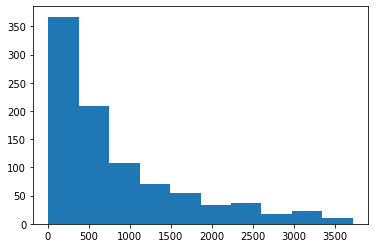

In [9]:
# Distribution for Pay per Student after outliers were removed
plt.hist(df['Pay per Student'])

(array([  1.,   2.,   4.,   5.,  15.,  22.,  47.,  98., 186., 547.]),
 array([  4.7 ,  14.23,  23.76,  33.29,  42.82,  52.35,  61.88,  71.41,
         80.94,  90.47, 100.  ]),
 <a list of 10 Patch objects>)

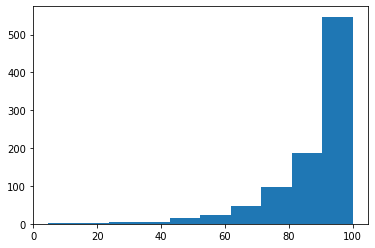

In [10]:
# Distribution for Instructor Recommendation
# Highly left skewed
plt.hist(df['Rcmnd Instr'])

In [11]:
# Determine Outliers for Recommendations
lower, upper = np.percentile(df['Rcmnd Instr'], [25, 75])
iqr = upper - lower
lower_cutoff = lower - 1.5 * iqr
upper_cutoff = upper + 1.5 * iqr
print("Lower 25: ", lower_cutoff, "\nUpper 25: ", upper_cutoff)

df = (df[(df['Rcmnd Instr'] >= lower_cutoff) & (df['Rcmnd Instr'] <= upper_cutoff)])
df

Lower 25:  62.355357142857166 
Upper 25:  118.76011904761904


,Title,Regular Pay,Department,Rcmnd Instr,Average Grade Expected,Classes Taught,Enrolled,Pay per Student
0,LECTURER - ACADEMIC YEAR,40000.0,Electrical & Computer Eng.,95.120000,3.802000,5.0,196.0,204.081633
1,LECTURER - ACADEMIC YEAR - ONE OR TWO QUARTERS,10000.0,Psychology,97.000000,3.250000,1.0,52.0,192.307692
2,LECTURER - ACADEMIC YEAR - CONTINUING,50000.0,Chemistry,90.575000,3.115000,4.0,1356.0,36.873156
3,LECTURER - ACADEMIC YEAR - ONE OR TWO QUARTERS,20000.0,Mathematics,90.450000,3.350000,2.0,491.0,40.733198
4,LECTURER - ACADEMIC YEAR - CONTINUING,130000.0,Education Studies,97.900000,3.980000,1.0,55.0,2363.636364
...,...,...,...,...,...,...,...,...
1029,ASSOC PROF - ACADEMIC YEAR - B/E/E,120000.0,other,97.033333,3.196667,3.0,305.0,393.442623
1031,ASST PROF - ACADEMIC YEAR,100000.0,Chemistry,92.300000,3.125000,2.0,513.0,194.931774
1032,VIS ASSOC PROF,140000.0,Rady School of Management,91.216667,3.546667,6.0,401.0,349.127182
1033,PROF - ACADEMIC YEAR,140000.0,Mathematics,96.150000,3.210000,2.0,43.0,3255.813953


(array([ 18.,  15.,  27.,  33.,  51.,  57.,  77., 109., 189., 300.]),
 array([ 62.45 ,  66.205,  69.96 ,  73.715,  77.47 ,  81.225,  84.98 ,
         88.735,  92.49 ,  96.245, 100.   ]),
 <a list of 10 Patch objects>)

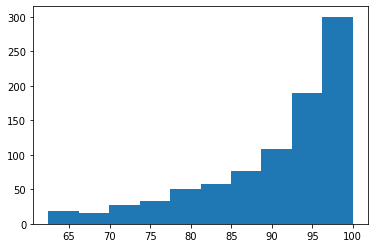

In [12]:
# Distribution for Instructor Recommendation after outliers were removed
plt.hist(df['Rcmnd Instr'])

(array([  2.,   8.,  15.,  32.,  92., 169., 181., 166., 136.,  75.]),
 array([2.39 , 2.551, 2.712, 2.873, 3.034, 3.195, 3.356, 3.517, 3.678,
        3.839, 4.   ]),
 <a list of 10 Patch objects>)

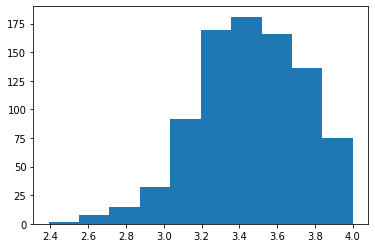

In [13]:
# Distribution for Grade Expected
# Somewhat normally distributed
plt.hist(df['Average Grade Expected'])

In [14]:
# Determine Outliers for Average Grade Expected
lower, upper = np.percentile(df['Average Grade Expected'], [25, 75])
iqr = upper - lower
lower_cutoff = lower - 1.5 * iqr
upper_cutoff = upper + 1.5 * iqr
print("Lower 25: ", lower_cutoff, "\nUpper 25: ", upper_cutoff)

df = (df[(df['Average Grade Expected'] >= lower_cutoff) & (df['Average Grade Expected'] <= upper_cutoff)])
df

Lower 25:  2.67 
Upper 25:  4.27


,Title,Regular Pay,Department,Rcmnd Instr,Average Grade Expected,Classes Taught,Enrolled,Pay per Student
0,LECTURER - ACADEMIC YEAR,40000.0,Electrical & Computer Eng.,95.120000,3.802000,5.0,196.0,204.081633
1,LECTURER - ACADEMIC YEAR - ONE OR TWO QUARTERS,10000.0,Psychology,97.000000,3.250000,1.0,52.0,192.307692
2,LECTURER - ACADEMIC YEAR - CONTINUING,50000.0,Chemistry,90.575000,3.115000,4.0,1356.0,36.873156
3,LECTURER - ACADEMIC YEAR - ONE OR TWO QUARTERS,20000.0,Mathematics,90.450000,3.350000,2.0,491.0,40.733198
4,LECTURER - ACADEMIC YEAR - CONTINUING,130000.0,Education Studies,97.900000,3.980000,1.0,55.0,2363.636364
...,...,...,...,...,...,...,...,...
1029,ASSOC PROF - ACADEMIC YEAR - B/E/E,120000.0,other,97.033333,3.196667,3.0,305.0,393.442623
1031,ASST PROF - ACADEMIC YEAR,100000.0,Chemistry,92.300000,3.125000,2.0,513.0,194.931774
1032,VIS ASSOC PROF,140000.0,Rady School of Management,91.216667,3.546667,6.0,401.0,349.127182
1033,PROF - ACADEMIC YEAR,140000.0,Mathematics,96.150000,3.210000,2.0,43.0,3255.813953


(array([  8.,  16.,  30.,  91., 147., 138., 148., 124., 101.,  65.]),
 array([2.67 , 2.803, 2.936, 3.069, 3.202, 3.335, 3.468, 3.601, 3.734,
        3.867, 4.   ]),
 <a list of 10 Patch objects>)

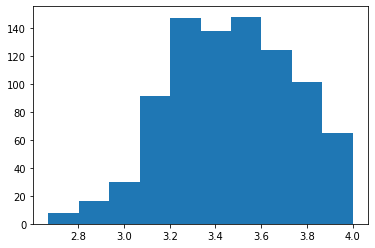

In [15]:
# Distribution for Grade Expected after outliers were removed
plt.hist(df['Average Grade Expected'])

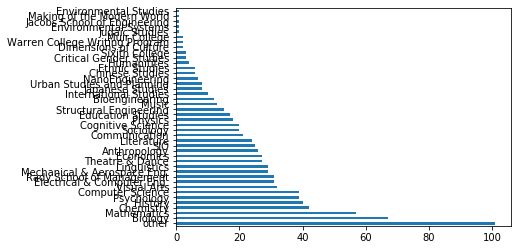

In [16]:
df['Department'].value_counts().plot(kind='barh')

In [17]:
df = (df[(df['Department'] != 'other')])

# Determine Outliers for Department
lower, upper = np.percentile(df['Department'].value_counts(), [25, 75])
iqr = upper - lower
lower_cutoff = lower - 1.5 * iqr
upper_cutoff = upper + 1.5 * iqr
print("Lower 25: ", lower_cutoff, "\nUpper 25: ", upper_cutoff)

# To see which ones are outliers
df['Department'].value_counts()

# Get rid of the outliers
df = (df[(df['Department'] != 'Mathematics') & (df['Department'] != 'Biology')])
df

Lower 25:  -33.5 
Upper 25:  66.5


,Title,Regular Pay,Department,Rcmnd Instr,Average Grade Expected,Classes Taught,Enrolled,Pay per Student
0,LECTURER - ACADEMIC YEAR,40000.0,Electrical & Computer Eng.,95.120000,3.802000,5.0,196.0,204.081633
1,LECTURER - ACADEMIC YEAR - ONE OR TWO QUARTERS,10000.0,Psychology,97.000000,3.250000,1.0,52.0,192.307692
2,LECTURER - ACADEMIC YEAR - CONTINUING,50000.0,Chemistry,90.575000,3.115000,4.0,1356.0,36.873156
4,LECTURER - ACADEMIC YEAR - CONTINUING,130000.0,Education Studies,97.900000,3.980000,1.0,55.0,2363.636364
5,LECTURER - ACADEMIC YEAR - ONE OR TWO QUARTERS,30000.0,Computer Science,83.200000,3.270000,2.0,243.0,123.456790
...,...,...,...,...,...,...,...,...
1021,PROF - ACADEMIC YEAR - B/E/E,130000.0,Bioengineering,94.700000,3.540000,1.0,63.0,2063.492063
1023,ASST PROF - ACADEMIC YEAR - B/E/E,110000.0,Computer Science,80.400000,3.310000,1.0,123.0,894.308943
1027,PROF - ACADEMIC YEAR - B/E/E,140000.0,Bioengineering,76.000000,3.590000,1.0,73.0,1917.808219
1031,ASST PROF - ACADEMIC YEAR,100000.0,Chemistry,92.300000,3.125000,2.0,513.0,194.931774


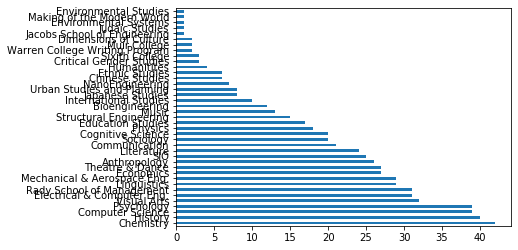

In [18]:
df['Department'].value_counts().plot(kind='barh')

## Relationships between Variables

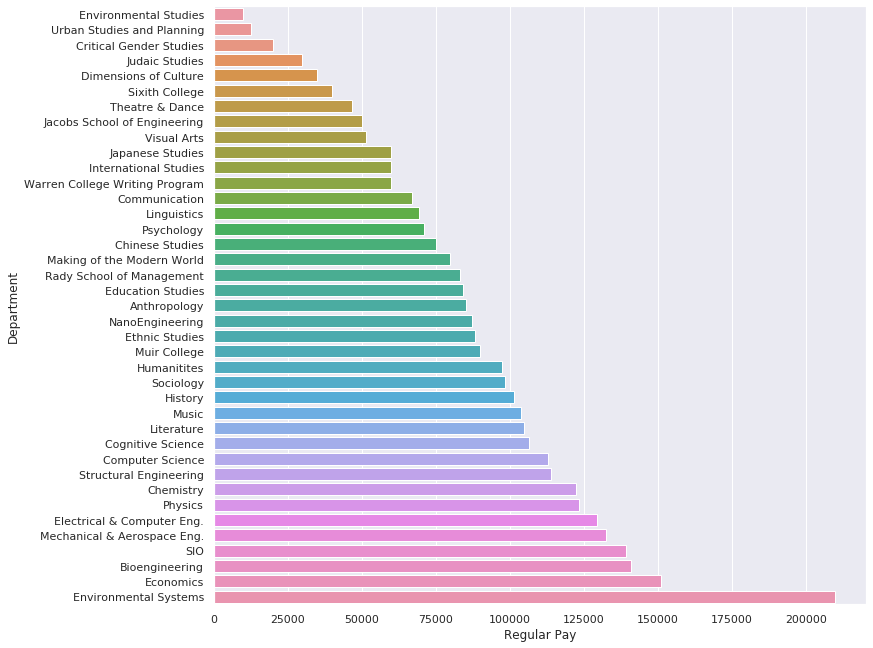

In [19]:
# Create by_dep as a df grouped by department of instructor
by_dep = df.groupby(['Department']).mean()

# Graph this in a bar chart on sorted values
sns.set(rc={'figure.figsize':(11.7,11)})
sns.barplot(y=by_dep.index, x=by_dep['Regular Pay'], order=by_dep.sort_values('Regular Pay').index)

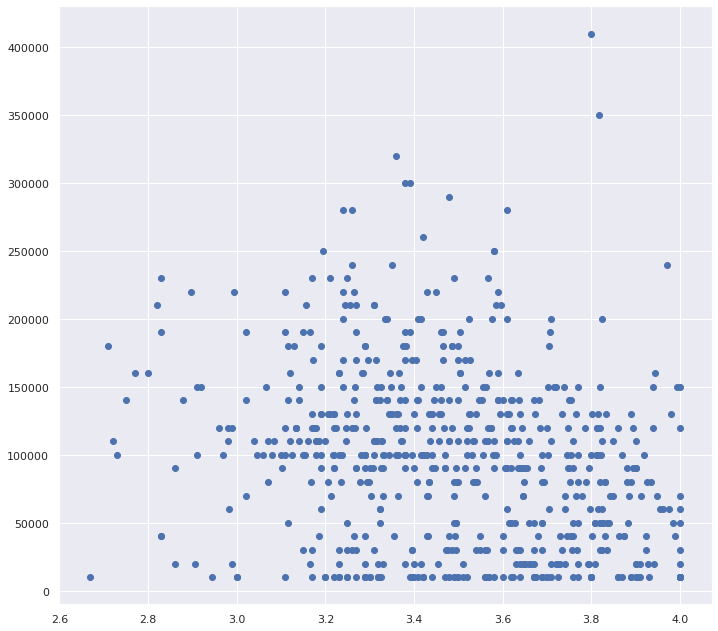

In [41]:
# Grade vs. Pay per Student
plt.scatter(df['Average Grade Expected'],df['Regular Pay'])

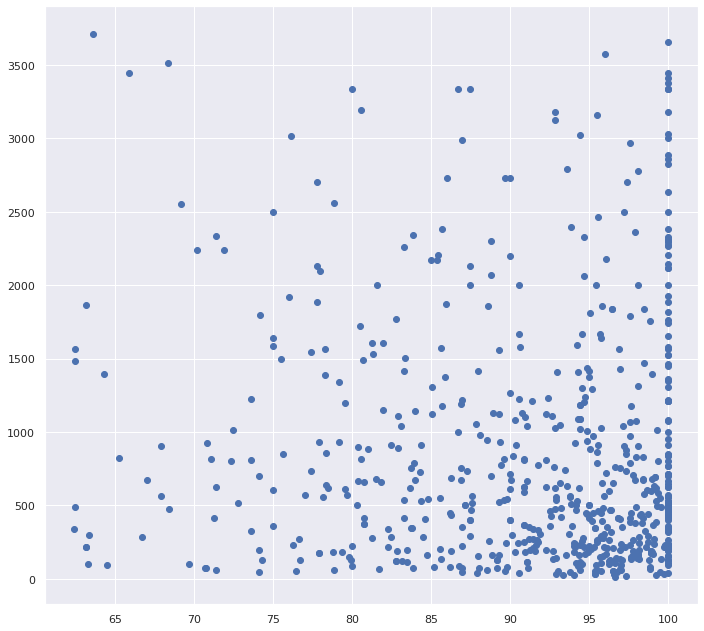

In [21]:
# Recommendation of Instructor vs. Pay per Student
plt.scatter(df['Rcmnd Instr'],df['Pay per Student'])

## Transforming Data to Normal Distributions

In [22]:
df['PPS_log10'] = df['Pay per Student'].apply(np.log10)
df['RI_log10'] = df['Rcmnd Instr'].apply(np.log10)
df['AGE_log10'] = df['Average Grade Expected'].apply(np.log10)

(array([  6.,   9.,  16.,  28.,  83., 114., 111., 104., 106.,  66.]),
 array([0.42651126, 0.44406613, 0.46162101, 0.47917588, 0.49673075,
        0.51428563, 0.5318405 , 0.54939537, 0.56695025, 0.58450512,
        0.60205999]),
 <a list of 10 Patch objects>)

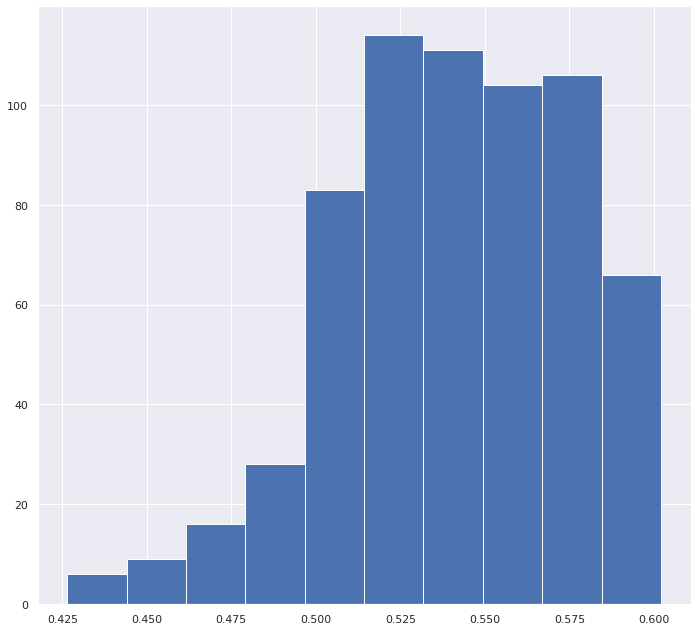

In [23]:
plt.hist(df['AGE_log10'])

(array([  1.,   9.,  22.,  30.,  72.,  95., 125., 121.,  96.,  72.]),
 array([1.03857891, 1.29170855, 1.54483819, 1.79796783, 2.05109747,
        2.30422711, 2.55735675, 2.81048639, 3.06361603, 3.31674567,
        3.56987531]),
 <a list of 10 Patch objects>)

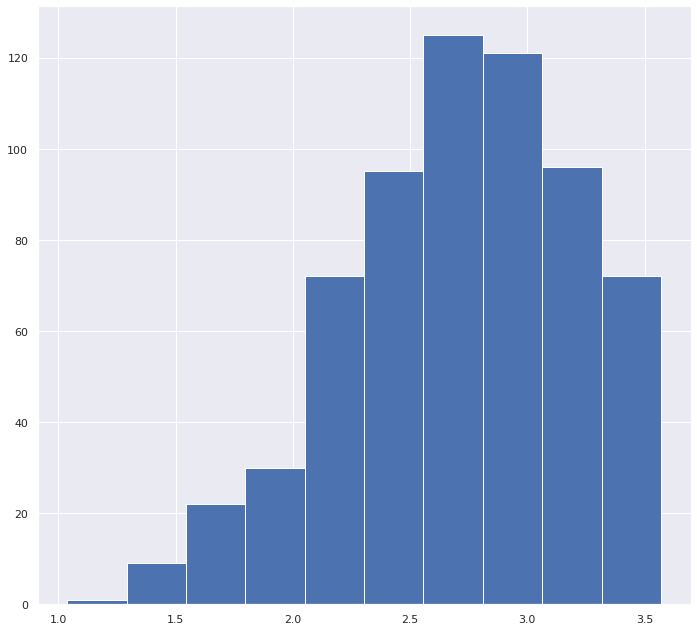

In [24]:
plt.hist(df['PPS_log10'])

(array([ 13.,   7.,  12.,  16.,  27.,  39.,  51.,  82., 119., 277.]),
 array([1.79553244, 1.8159792 , 1.83642595, 1.85687271, 1.87731947,
        1.89776622, 1.91821298, 1.93865973, 1.95910649, 1.97955324,
        2.        ]),
 <a list of 10 Patch objects>)

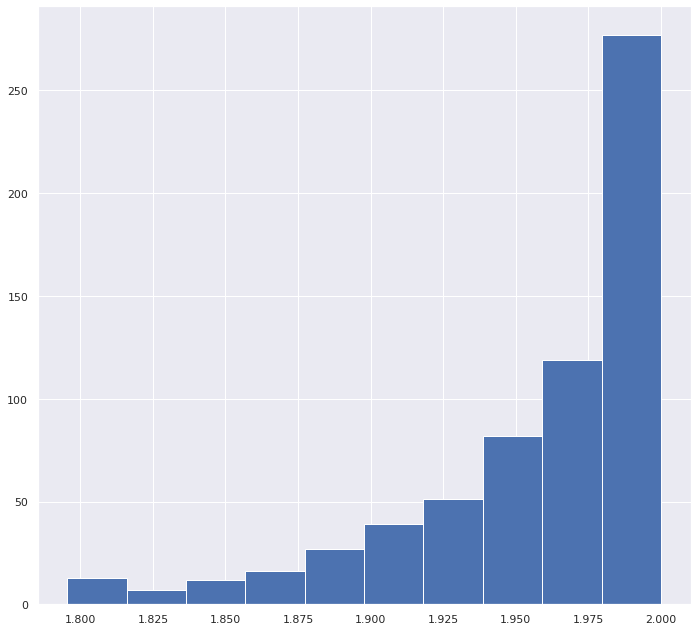

In [25]:
plt.hist(df['RI_log10'])

In [27]:
# rename Pay per Student
df['PPS'] = df['Pay per Student']

# run model
outcome, predictors = patsy.dmatrices('PPS ~ RI_log10 + AGE_log10', df)
mod = sm.OLS(outcome, predictors)  
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    PPS   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.029
Date:                Mon, 08 Jun 2020   Prob (F-statistic):              0.132
Time:                        21:04:57   Log-Likelihood:                -5231.0
No. Observations:                 643   AIC:                         1.047e+04
Df Residuals:                     640   BIC:                         1.048e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2727.3422   1387.594      1.966      0.0

In [28]:
df['RI'] = df['Rcmnd Instr']
df['AGE'] = df['Average Grade Expected']

# run model
outcome, predictors = patsy.dmatrices('PPS ~ RI + AGE', df)
mod = sm.OLS(outcome, predictors)  
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    PPS   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.897
Date:                Mon, 08 Jun 2020   Prob (F-statistic):              0.151
Time:                        21:12:54   Log-Likelihood:                -5231.1
No. Observations:                 643   AIC:                         1.047e+04
Df Residuals:                     640   BIC:                         1.048e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1738.1744    459.182      3.785      0.0

In [ ]:
# accept the null hypothesis

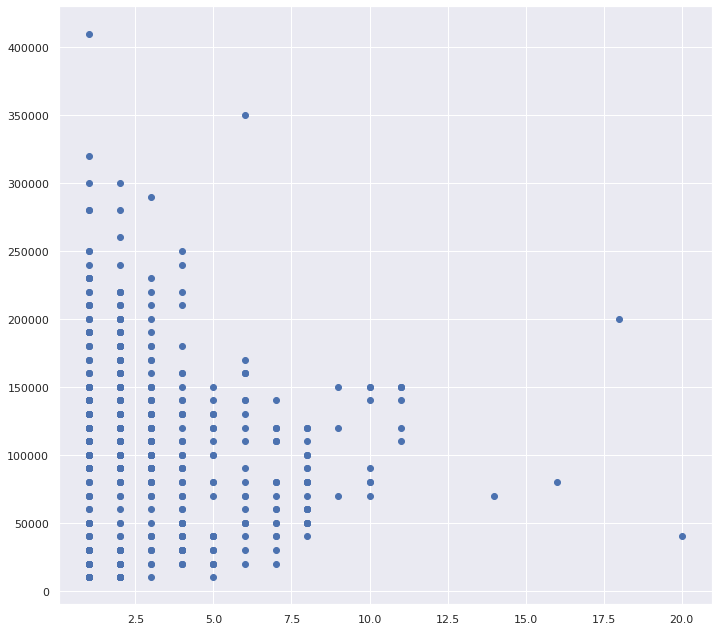

In [32]:
# Pay vs enrolled
plt.scatter(df['Classes Taught'],df['Regular Pay'])

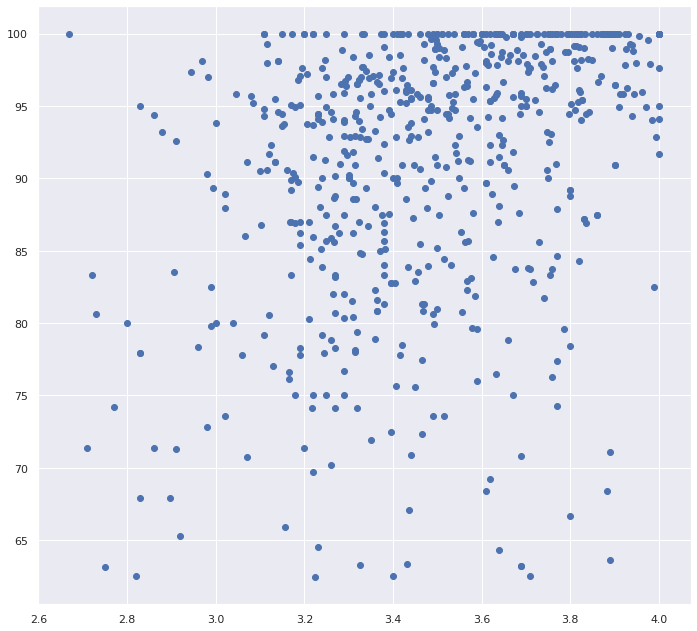

In [35]:

plt.scatter(df['AGE'], df['RI'])

In [36]:
# run model
outcome, predictors = patsy.dmatrices('RI ~ AGE', df)
mod = sm.OLS(outcome, predictors)  
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     RI   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     88.97
Date:                Mon, 08 Jun 2020   Prob (F-statistic):           7.23e-20
Time:                        21:26:22   Log-Likelihood:                -2282.1
No. Observations:                 643   AIC:                             4568.
Df Residuals:                     641   BIC:                             4577.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     51.5937      4.208     12.260      0.0

In [40]:
df['RP'] = df['Regular Pay']

outcome_1,predictors_1 = patsy.dmatrices('RP ~ Department',df)
mod_1 = sm.OLS(outcome_1,predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     RP   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     4.853
Date:                Mon, 08 Jun 2020   Prob (F-statistic):           7.28e-18
Time:                        21:32:33   Log-Likelihood:                -7954.4
No. Observations:                 643   AIC:                         1.599e+04
Df Residuals:                     604   BIC:                         1.616e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [42]:
df.corr()

,Regular Pay,Rcmnd Instr,Average Grade Expected,Classes Taught,Enrolled,Pay per Student,PPS_log10,RI_log10,AGE_log10,PPS,RI,AGE,RP
Regular Pay,1.000000,-0.144281,-0.249571,-0.006782,0.062596,0.468563,0.529643,-0.134434,-0.244376,0.468563,-0.144281,-0.249571,1.000000
Rcmnd Instr,-0.144281,1.000000,0.349116,0.145813,0.037681,-0.046252,-0.045033,0.997840,0.351374,-0.046252,1.000000,0.349116,-0.144281
Average Grade Expected,-0.249571,0.349116,1.000000,0.204898,-0.088614,-0.073551,-0.046913,0.337229,0.998642,-0.073551,0.349116,1.000000,-0.249571
Classes Taught,-0.006782,0.145813,0.204898,1.000000,0.513161,-0.349128,-0.394563,0.148776,0.202947,-0.349128,0.145813,0.204898,-0.006782
Enrolled,0.062596,0.037681,-0.088614,0.513161,1.000000,-0.408560,-0.610030,0.045684,-0.085484,-0.408560,0.037681,-0.088614,0.062596
Pay per Student,0.468563,-0.046252,-0.073551,-0.349128,-0.408560,1.000000,0.860132,-0.051574,-0.074281,1.000000,-0.046252,-0.073551,0.468563
PPS_log10,0.529643,-0.045033,-0.046913,-0.394563,-0.610030,0.860132,1.000000,-0.048295,-0.048228,0.860132,-0.045033,-0.046913,0.529643
RI_log10,-0.134434,0.997840,0.337229,0.148776,0.045684,-0.051574,-0.048295,1.000000,0.340130,-0.051574,0.997840,0.337229,-0.134434
AGE_log10,-0.244376,0.351374,0.998642,0.202947,-0.085484,-0.074281,-0.048228,0.340130,1.000000,-0.074281,0.351374,0.998642,-0.244376
PPS,0.468563,-0.046252,-0.073551,-0.349128,-0.408560,1.000000,0.860132,-0.051574,-0.074281,1.000000,-0.046252,-0.073551,0.468563
